# Data Cleaning and EDA #
The script has gathered up to 100 reviews per user for almost 300 users. Time to make sure all the data is present

In [1]:
import pandas as pd
import sqlite3
import numpy as np
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# File path to the consolidated data
path = '../data/interim/consolidated_data.csv'

In [3]:
df = pd.read_csv(path)
df.head()

,title,author,avg_rating,user_rating,cover_url,user_id
0,The Indispensable Calvin and Hobbes,"Watterson, Bill",4.70,5,https://i.gr-assets.com/images/S/compressed.ph...,1
1,The Days Are Just Packed,"Watterson, Bill",4.66,5,https://i.gr-assets.com/images/S/compressed.ph...,1
2,Harry Potter and the Half-Blood Prince,"Rowling, J.K.",4.58,5,https://i.gr-assets.com/images/S/compressed.ph...,1
3,Empire of Pain: The Secret History of the Sack...,"Keefe, Patrick Radden",4.54,5,https://i.gr-assets.com/images/S/compressed.ph...,1
4,Shoe Dog: A Memoir by the Creator of NIKE,"Knight, Phil",4.47,5,https://i.gr-assets.com/images/S/compressed.ph...,1


In [4]:
df.shape

(55014, 6)

In [5]:
df['title'].nunique()

24949

In [6]:
df['cover_url'].nunique()

29564

In [7]:
df.isna().sum()

title          0
author         0
avg_rating     0
user_rating    0
cover_url      0
user_id        0
dtype: int64

In [8]:
df.user_id.unique().dtype

dtype('int64')

In [9]:
non_integers = df[pd.to_numeric(df['user_id'], errors='coerce').isna()]
print(non_integers)

Empty DataFrame
Columns: [title, author, avg_rating, user_rating, cover_url, user_id]
Index: []


### First Impressions ###
There are 55,014 reviews here, and 29,949 unique books. I'm glad to see this much variety. Hopefully I don't end up recommending too many obscure books. There are more unique cover URLs due to different editions existing for many of the books.

# SQL Database Exploration #
Now I want to check out the relational database I made from the data

In [10]:
database_path = os.path.abspath(
            os.path.join(
                os.pardir,
                'data',
                'processed',
                'books.db'
                )
            )

conn = sqlite3.connect(database_path)

In [11]:
cur = conn.cursor()
cur.execute('SELECT * FROM Ratings LIMIT 10')
results = cur.fetchall()

for row in results:
    print(row)

(1, 1, 5, 4.7)
(31880928, 1, 1, 4.7)
(3472444, 1, 5, 4.7)
(269235, 1, 4, 4.7)
(122647, 1, 5, 4.7)
(2431437, 1, 5, 4.7)
(93149311, 1, 5, 4.7)
(31000456, 1, 4, 4.7)
(1413439, 1, 5, 4.7)
(16576124, 1, 5, 4.7)


In [12]:
cur = conn.cursor()
cur.execute('SELECT * FROM Books LIMIT 10')
results = cur.fetchall()

for row in results:
    print(row)

(1, 'The Indispensable Calvin and Hobbes', 'Watterson, Bill', 'https://i.gr-assets.com/images/S/compressed.photo.goodreads.com/books/1347311516l/24815._SX50_.jpg')
(2, 'The Days Are Just Packed', 'Watterson, Bill', 'https://i.gr-assets.com/images/S/compressed.photo.goodreads.com/books/1418211162l/24818._SX50_.jpg')
(3, 'Harry Potter and the Half-Blood Prince', 'Rowling, J.K.', 'https://i.gr-assets.com/images/S/compressed.photo.goodreads.com/books/1587697303l/1._SX50_.jpg')
(4, 'Empire of Pain: The Secret History of the Sackler Dynasty', 'Keefe, Patrick Radden', 'https://i.gr-assets.com/images/S/compressed.photo.goodreads.com/books/1611952917l/56343711._SY75_.jpg')
(5, 'Shoe Dog: A Memoir by the Creator of NIKE', 'Knight, Phil', 'https://i.gr-assets.com/images/S/compressed.photo.goodreads.com/books/1460439544l/29893493._SY75_.jpg')
(6, 'The Martian', 'Weir, Andy', 'https://i.gr-assets.com/images/S/compressed.photo.goodreads.com/books/1393422559l/17315048._SX50_.jpg')
(7, "The Ultimate H

In [13]:
cur.execute('SELECT COUNT(*) FROM Books')
book_count = cur.fetchone()
print(book_count)

(25548,)


In [14]:
cur.execute('SELECT COUNT(*) FROM Users')
user_count = cur.fetchone()
print(user_count)

(298,)


In [15]:
for row in conn.execute('PRAGMA table_info(Ratings)'):
    print(row)

(0, 'user_id', 'INTEGER', 0, None, 0)
(1, 'book_id', 'INTEGER', 0, None, 0)
(2, 'user_rating', 'INTEGER', 0, None, 0)
(3, 'avg_rating', 'REAL', 0, None, 0)


### Database Assessment ###
The database is correctly built with all books, users, and ratings accounted for! There are 25,548 unique combinations of book title and cover URL. While I'd like to go through and merge all unique editions into a single entry, I don't expect it would be worth the effort for the purposes of this project.

## EDA ##
Now I want to take a look at the distributions of books and ratings.

### Most Popular Books ###

In [16]:
query = '''
SELECT b.title, AVG(r.avg_rating) as avg_rating, COUNT(r.user_rating) as votes
FROM Books b
JOIN Ratings r ON b.book_id = r.book_id
GROUP BY b.title
'''
books_avg_ratings_df = pd.read_sql_query(query, conn)

In [17]:
books_avg_ratings_df.sort_values(by = ['votes', 'avg_rating'], ascending = [False, False]).head(10)

,title,avg_rating,votes
19523,The Hunger Games,4.330000,173
8061,Harry Potter and the Sorcerer's Stone,4.470000,158
8046,Harry Potter and the Chamber of Secrets,4.430000,150
8060,Harry Potter and the Prisoner of Azkaban,4.580000,147
3636,Catching Fire,4.320000,147
22491,To Kill a Mockingbird,4.260000,147
8055,Harry Potter and the Goblet of Fire,4.560000,146
19245,The Great Gatsby,3.930000,146
22841,Twilight,3.640000,144
8057,Harry Potter and the Order of the Phoenix,4.502324,142


The most popular books are, unsurprisingly, the Hunger Games and Harry Potter series. Then I see some classics and the first Twilight book.

In [18]:
ratings_df = pd.read_sql_query('SELECT * FROM Ratings', conn)
ratings_df.head()

,user_id,book_id,user_rating,avg_rating
0,1,1,5,4.7
1,31880928,1,1,4.7
2,3472444,1,5,4.7
3,269235,1,4,4.7
4,122647,1,5,4.7


### Least Popular Books ###
Although I sorted each user's shelf by most popular books, I'm curious to know which are the least popular books in the dataset.

In [19]:
num_reviews = ratings_df['book_id'].value_counts()
len(num_reviews.unique())

126

In [20]:
len(ratings_df['book_id'].unique())

25548

There are 126 unique value counts, so if I make a histogram with 102 bins, each bin will account for a distinct value count. This way I can see the distribution of book popularity.

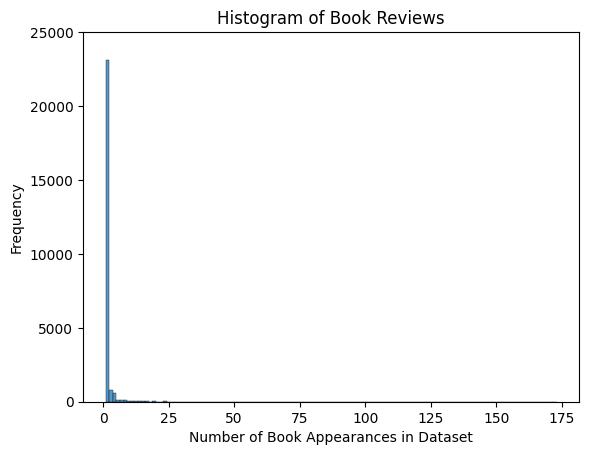

In [37]:
sns.histplot(data = num_reviews, bins = 126)
plt.title('Histogram of Book Reviews')
plt.xlabel('Number of Book Appearances in Dataset')
plt.ylim(0, 25000)
plt.ylabel('Frequency')
plt.show()

Over 20,000 of the 25,548 unique books only appear once in the dataset. I wonder how many books would remain if I dropped all books with fewer than 10 appearances.

In [22]:
min_books = 10
popular_filter = ratings_df['book_id'].value_counts() > min_books
popular_filter = popular_filter[popular_filter].index.to_list()
popular_df = ratings_df[ratings_df['book_id'].isin(popular_filter)]
len(popular_df['book_id'].value_counts().unique())

116

Only 116 books remain if I filter out the books with fewer than 10 reviews. I don't think this is a good idea. If I was starting with a much larger dataset I could make the argument for this approach, but I have too few books to eliminate most of them.

### User Rating Distribution ###
Now I want to see if user ratings are distributed normally.

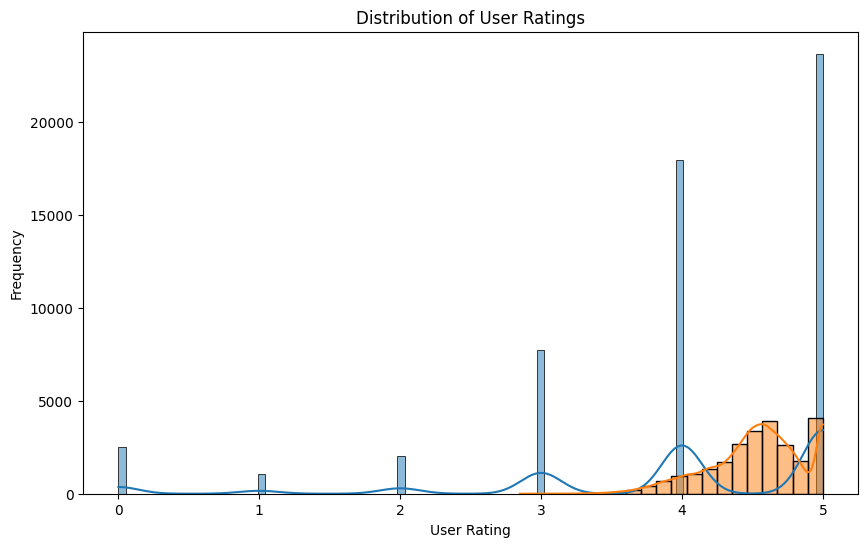

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(ratings_df['user_rating'], kde = True)
sns.histplot(books_avg_ratings_df['avg_rating'], kde = True, bins = 20)
plt.title('Distribution of User Ratings')
plt.xlabel('User Rating')
plt.ylabel('Frequency')
plt.show()

The above histograms show the distribution of user ratings in blue and the distribution of average ratings in orange. It is not surprising that the most popular users would give the most popular books a high rating generally. I am a little surprised that these users give out so many 5-star reviews. While it is very subjective, many Goodreads users adhere to the same rating scale, where a 5-star rating is reserved for the user's favorite books of all time. But I suppose that popular, well-reviewed books are exactly that for a reason. The median book in this dataset has an average rating of just over 4 stars. The distribution of average ratings has a longer tail on the left, which makes sense due to the cap at 5 stars. I'm a little surprised to see that some of the books on this list managed to be popular enough but also average fewer than 3 stars.

In [24]:
query = '''
SELECT user_id, AVG(user_rating) as user_avg_rating
FROM Ratings r
GROUP BY user_id
'''
user_avg_ratings_df = pd.read_sql_query(query, conn)

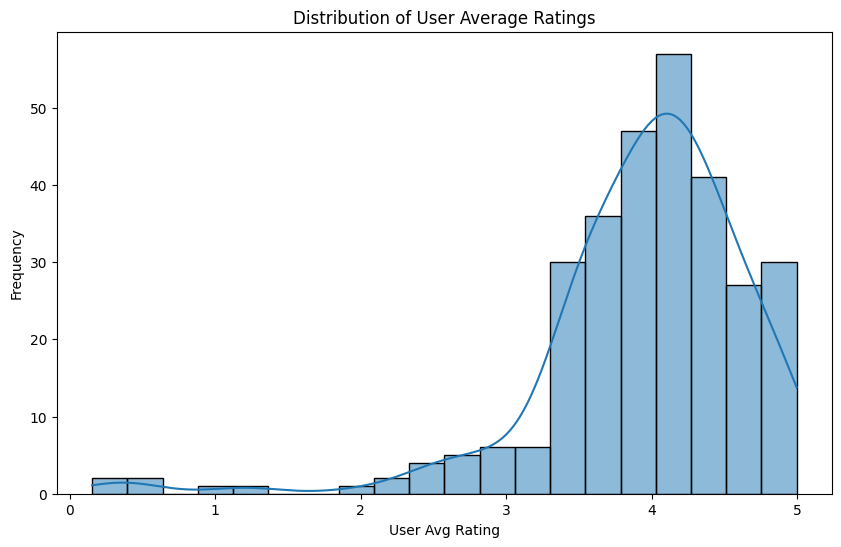

In [25]:
plt.figure(figsize=(10, 6))
sns.histplot(user_avg_ratings_df['user_avg_rating'], kde = True, bins = 20)
plt.title('Distribution of User Average Ratings')
plt.xlabel('User Avg Rating')
plt.ylabel('Frequency')
plt.show()

This histogram plot shows the distribution of each user's average rating. Some users clearly love the popular books, giving out an average of almost 5 stars. Many users are clustered around the 4-star average rating. Some users, on the other hand, seem to be haters and give out generally very low scores. I'll check those users out.

### Low-Rater Investigation ###
I'll take a look at a particular user who gives out very low scores on average.

In [26]:
query = '''
SELECT user_id, SUM(user_rating == 0) AS zero_star, SUM(user_rating == 1) AS one_star, SUM(user_rating == 2) AS two_star,
SUM(user_rating == 3) AS three_star, SUM(user_rating == 4) AS four_star,
SUM(user_rating == 5) AS five_star, 
AVG(user_rating) AS user_avg
FROM Ratings r
GROUP BY user_id
HAVING AVG(user_rating) < 3
'''

low_ratings_df = pd.read_sql_query(query, conn)

In [27]:
low_ratings_df

,user_id,zero_star,one_star,two_star,three_star,four_star,five_star,user_avg
0,914795,0,25,94,37,30,2,2.414894
1,922495,71,0,2,4,8,103,2.994681
2,1005037,63,5,6,24,44,40,2.554945
3,1113032,70,0,1,28,32,14,1.958621
4,1151637,74,2,6,13,34,63,2.625000
5,1162953,4,5,56,87,27,4,2.765027
6,1323157,44,3,9,24,67,33,2.922222
7,2164884,22,3,33,95,42,3,2.712121
8,3571171,10,8,27,86,36,9,2.892045
9,3734681,109,0,0,6,20,21,1.301282


Right away I can see some users rarely rate books, often just logging them as "read" without assigning a score. These are users which I would likely drop from the training data if I refined my model further. As it stands, I'll keep them since I don't have a trememndously large dataset to begin with. I'm more intrigued by the users who score each book but are very stingy with high scores. User 3258178 for instance has no zeros and only 9 fives. They mostly rate books either 2 or 3 stars. 

In [28]:
query = '''
SELECT r.user_id, b.title, r.user_rating, r.avg_rating 
FROM Ratings r
JOIN Books b ON b.book_id = r.book_id
WHERE user_id == 3258178
'''

user_3258178_df = pd.read_sql_query(query, conn)

In [29]:
differenced_df = user_3258178_df.assign(diff = (user_3258178_df['user_rating']) - user_3258178_df['avg_rating'])
differenced_df.sort_values(by = 'diff', ascending = False)

,user_id,title,user_rating,avg_rating,diff
47,3258178,Macbeth,5,3.90,1.10
49,3258178,Fahrenheit 451,5,3.97,1.03
69,3258178,Prince Caspian - Book 2 in the Chronicles of N...,5,3.98,1.02
16,3258178,Animal Farm,5,3.98,1.02
68,3258178,"The Voyage Of The ""Dawn Treader""",5,4.09,0.91
...,...,...,...,...,...
8,3258178,The Shining,1,4.26,-3.26
15,3258178,Pride and Prejudice,1,4.28,-3.28
20,3258178,Gone with the Wind,1,4.31,-3.31
196,3258178,The Great War For Civilisation: The Conquest o...,0,4.40,-4.40


In [30]:
differenced_df['diff'].loc[differenced_df['diff'] > 0].count()

37

In [31]:
user_avg = np.mean(differenced_df['user_rating'])
goodreads_avg = np.mean(differenced_df['avg_rating'])
diff_avg = np.mean(differenced_df['diff'])
print(f"The User averages a score of {user_avg} stars compared to a Goodreads average of \
{goodreads_avg:0.2f} stars\n for books in the user's library. This is an average differential of \
{diff_avg:0.2f} stars.")

The User averages a score of 3.233502538071066 stars compared to a Goodreads average of 4.28 stars
 for books in the user's library. This is an average differential of -1.05 stars.


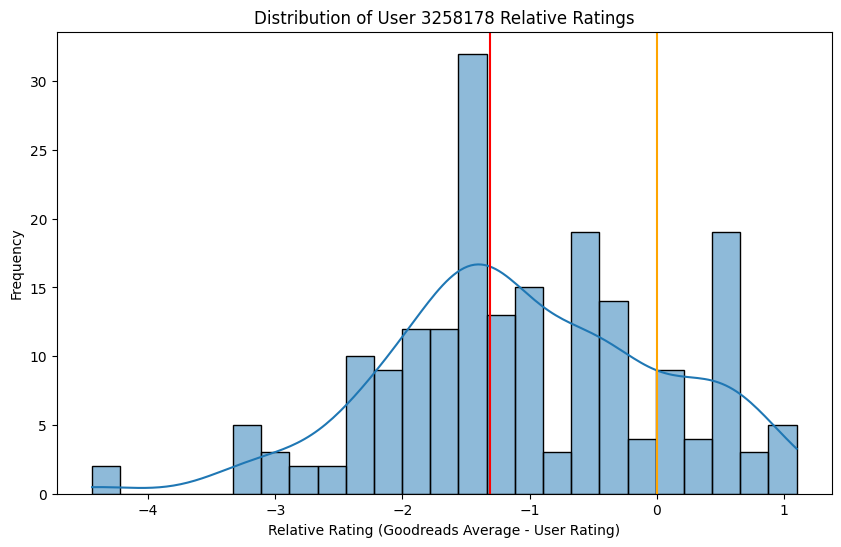

In [32]:
plt.figure(figsize=(10, 6))
sns.histplot(differenced_df['diff'], kde = True, bins = 25)
plt.axvline(0, 0, 1, color = 'orange')
plt.axvline(-1.31, 0, 1, color = 'red')
plt.title('Distribution of User 3258178 Relative Ratings')
plt.xlabel('Relative Rating (Goodreads Average - User Rating)')
plt.ylabel('Frequency')
plt.show()

This particular user is  particularly strict with their ratings. The user averages a rating of 2.76 stars, which is over a full star less than the average Goodreads rating for the books in their library. They have rated plenty of books above the Goodreads average, so I wouldn't consider them a hater. They just tend not to love the most popular books.

User 77805119 doesn't merit much analysis. They seem to treat the ratings as binary, rating most books either 0 or 5 stars. This could be good feedback for a model, equating to either a "yes" or "no" recommendation.

In [33]:
conn.close()

# Conclusion #
This exploration has shown me that the most popular Goodreads users do not have a uniform system for rating books. Many of them use a similar scale : 
* 1 star - I did not like it
* 2 stars - It was fine
* 3 stars - I liked it
* 4 stars - I really liked it

Other users rate very differently. The model will have to account for these variations as it learns how to recommend books based on user similarity scores..